In [3]:
import numpy as np
import os
import re

In [4]:
def load_word_embeddings(src_path):
    """
    Funzione presa dal notebook lez. 12
    """
    embeddings = dict()
    for line in open(src_path, 'r'):
        line = line.strip().split('\t')
        word = line[0]
        embedding = line[1:]
        embedding = [float(comp) for comp in embedding] # convertiamo le componenti dell'embedding in float
        embeddings[word] = np.asarray(embedding) # trasformiamo la lista delle componenti in un vettore di numpy
    return embeddings

def get_digits(text):
    """
    Funzione presa dal notebook lez. 12
    """
    try:
      val = int(text)
    except:
      text = re.sub('\d', '@Dg', text)
      return text
    if val >= 0 and val < 2100:
      return str(val)
    else:
      return "DIGLEN_" + str(len(str(val)))

def normalize_text(word):
    """
    Funzione presa dal notebook lez. 12
    """
    if "http" in word or ("." in word and "/" in word):
      word = str("___URL___")
      return word
    if len(word) > 26:
      return "__LONG-LONG__"
    new_word = get_digits(word)
    if new_word != word:
      word = new_word
    if word[0].isupper():
      word = word.capitalize()
    else:
      word = word.lower()
    return word

def get_tokens_from_file(src_path):
    """
    Funzione presa dal notebook lez. 12
    """
    document_tokens = []
    lines_to_skip = 0
    take_pos = False
    for line in open(src_path, 'r'):
        # print(f'\nRiga: {line.strip()}')
        if line[0].isdigit():
            splitted_line = line.strip().split('\t')
            if '-' in splitted_line[0]:
                # print('Ho trovato un - ')
                skip_ids = splitted_line[0].split('-')
                # print('Indici da saltare', skip_ids)
                lines_to_skip = int(skip_ids[1]) - int(skip_ids[0]) + 1 # l'indice ci indica quali righe saltare
                take_pos = True # booleano che indica che dobbiamo prendere la pos della prossima parola
                word = normalize_text(splitted_line[1])
                pos = splitted_line[3]
                token = {
                    'word': word,
                    'pos': '_'
                }
                # print(f'Preso token {word}')
                document_tokens.append(token)
            else:
                if lines_to_skip == 0:
                    
                    word = normalize_text(splitted_line[1])
                    pos = splitted_line[3]
                    token = {
                        'word': word,
                        'pos': pos
                    }
                    # print(f'Preso token {word}')
                    document_tokens.append(token)
                if take_pos:
                    pos = splitted_line[3]
                    document_tokens[-1]['pos'] = pos
                    take_pos = False
                lines_to_skip = max(0, lines_to_skip-1)
    return document_tokens

In [5]:
# per creare la lista dei nomi dei file e la lista delle label sfrutto il fatto che so che la prima metà è sempre negativa, mentre la seconda metà è sempre positiva
file_names_train_prompt = [f'../data/_profiled/TED_split/train/{n}_0_prompt.conllu' for n in range(0,4000)] + [f'../data/_profiled/TED_split/train/{n}_1_prompt.conllu' for n in range(4000,8000)]
file_names_train_target = [f'../data/_profiled/TED_split/train/{n}_0_target.conllu' for n in range(0,4000)] + [f'../data/_profiled/TED_split/train/{n}_1_target.conllu' for n in range(4000,8000)]
labels_train = [0]*4000 + [1] *4000 

file_names_test_prompt = [f'../data/_profiled/TED_split/test/{n}_0_prompt.conllu' for n in range(0,400)] + [f'../data/_profiled/TED_split/test/{n}_1_prompt.conllu' for n in range(400,800)]
file_names_test_target = [f'../data/_profiled/TED_split/test/{n}_0_target.conllu' for n in range(0,400)] + [f'../data/_profiled/TED_split/test/{n}_1_target.conllu' for n in range(400,800)]
labels_test = [0]*400 + [1] *400

In [6]:
# carico i word embeddings
embeddings = load_word_embeddings('../data/embedding/itwac128_nosplit.txt')

In [7]:
# prova
get_tokens_from_file(file_names_train_prompt[0])

[{'word': 'Per', 'pos': 'ADP'},
 {'word': 'questa', 'pos': 'DET'},
 {'word': 'cosa', 'pos': 'NOUN'},
 {'word': 'io', 'pos': 'PRON'},
 {'word': 'chiedo', 'pos': 'VERB'},
 {'word': 'aiuto', 'pos': 'NOUN'},
 {'word': 'a', 'pos': 'ADP'},
 {'word': 'un', 'pos': 'DET'},
 {'word': 'signore', 'pos': 'NOUN'},
 {'word': 'che', 'pos': 'PRON'},
 {'word': 'si', 'pos': 'PRON'},
 {'word': 'chiama', 'pos': 'VERB'},
 {'word': 'Watzlawick', 'pos': 'PROPN'},
 {'word': '.', 'pos': 'PUNCT'},
 {'word': "E'", 'pos': 'AUX'},
 {'word': 'uno', 'pos': 'DET'},
 {'word': 'psicologo', 'pos': 'NOUN'},
 {'word': ',', 'pos': 'PUNCT'},
 {'word': 'ed', 'pos': 'CCONJ'},
 {'word': 'è', 'pos': 'AUX'},
 {'word': 'uno', 'pos': 'PRON'},
 {'word': 'che', 'pos': 'PRON'},
 {'word': 'con', 'pos': 'ADP'},
 {'word': 'un', 'pos': 'DET'},
 {'word': 'nome', 'pos': 'NOUN'},
 {'word': 'così', 'pos': 'ADV'},
 {'word': ',', 'pos': 'PUNCT'},
 {'word': 'come', 'pos': 'ADP'},
 {'word': 'minimo', 'pos': 'NOUN'},
 {'word': 'doveva', 'pos': 'AU

In [8]:
import math
from keras.utils import pad_sequences
import tensorflow as tf

def get_embeddings(file_name: str, embeddings:dict, filter:list=['NOUN', 'VERB'], combine:str='mean'):
    """
    Questa funzione serve per estrarre gli embedding da un file, ed eventualmente combinarli.

    - filter: lista che contiene le POS da considerare, se vuota, saranno considerati tutti i token.
    - combine: metofo per combinare la lista dei vettori del documento, se None, sarà direttamente restituita la lista.
    """
    tok_list_raw = get_tokens_from_file(file_name)
    
    embeddings_list = []

    for el in tok_list_raw:
        if el['pos'] in filter:
            try:
                embeddings_list.append(embeddings[el['word']])
            except KeyError:
                pass

    if len(embeddings_list) == 0: # se una frase non ha nessun elemento che passa il filtro, allora metto tutto, sennò genererebbe degli errori
        for el in tok_list_raw:
            try:
                embeddings_list.append(embeddings[el['word']])
            except KeyError:
                pass

    tok_list = np.array(embeddings_list)
    
    if combine == None:
        return tok_list
    if combine == 'mean':
        return np.mean(tok_list, axis=0)
    if combine == 'median':
        return np.median(tok_list, axis=0)
    if combine == 'sum':
        return np.sum(tok_list, axis=0)
    

def euc(a,b):
    # distanza euclidea
    return np.linalg.norm(a - b)

def manhattan(a,b):
    # manhattan distance
    return np.linalg.norm(a - b, ord=1)

def cosine_distance(a,b):
    # 1 - cosine_similarity
    return 1 - np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))


def get_dataset_combined(file_names_prompt, file_names_target, inner_combine='median', outer_combine='abs_diff', filter=[], min_dist_function=euc):
    """
    Funzione che, data la lista dei path dei file prompt e target, per ogni coppia estrae gli embedding, e permette di combinarli in diversi modi, 
    restituendo alla fine un dataset con shape (n, 128).

    - inner_combine: stabilisce il metodo per combinare gli embeddinge all'interno del prompt e del target. 
    - outer_combine: stabilisce il metodo per combinare gli embedding rappresentativi del prompt, con quelli del target.
        - se = 'min_dist', dati gli embedding del prompt e del target, seleziona la coppia di vettori con la minor distanza, e usa come rappresentazione la differenza assoluta tra i due; inner_combine deve essere impostato a None.
    - min_dist_function: serve solo se outer_combine='min_dist', funzione che calcola la distanza tra due vettori. (non similarità!)

    """
    data = np.zeros((len(file_names_prompt), 128))

    for i,file_prompt, file_target in zip(range(0,len(file_names_prompt)),file_names_prompt, file_names_target):
        prompt_emb = get_embeddings(file_prompt, embeddings, combine=inner_combine, filter=filter)
        target_emb = get_embeddings(file_target, embeddings, combine=inner_combine, filter=filter)


        if outer_combine == 'squared_diff':
            data[i,:] = (prompt_emb - target_emb)**2 # differenza al quadrato

        if outer_combine == 'mean':
            data[i,:] = np.mean(np.concatenate([prompt_emb, target_emb], axis=0), axis=0) # media tra i vettori

        if outer_combine == 'abs_diff':
            data[i,:] = np.abs(prompt_emb - target_emb) # differenza assoluta

        if outer_combine == 'min_dist': # differenza assoluta tra i due token più vicini nello spazio
            min_dist = np.inf # qui tengo la distanza minima
            diff = [] # qui metterò il vettore rappresentativo
            for j in range(prompt_emb.shape[0]):
                for k in range(target_emb.shape[0]):
                    dist =  min_dist_function(prompt_emb[j],target_emb[k]) 
                    if dist < min_dist:
                        diff = np.abs(prompt_emb[j] - target_emb[k])
                        min_dist = dist
            data[i,:] = diff


        #if i % 400 == 0:
         #   print(i)


    return data




### Conservo i dataset sui quali fare validazione e test

Dataset min_dist, considero i vettori degli embedding con minima distanza tra quelli del prompt e quelli del target, e uso la differenza assoluta tra i due come rappresentazione.
Delle prove in validazione sono state svolte per scegliere la configurazione ideale degli iperparametri di get_dataset_combined

In [9]:
X_train_dist = get_dataset_combined(file_names_train_prompt, file_names_train_target, outer_combine='min_dist', 
                                    inner_combine=None, filter=['NOUN','PROPN', 'VERB', 'ADJ'], min_dist_function=euc)
X_test_dist = get_dataset_combined(file_names_test_prompt, file_names_test_target, outer_combine='min_dist', 
                                    inner_combine=None, filter=['NOUN','PROPN', 'VERB', 'ADJ'], min_dist_function=euc)

Dataset diff, prendo i vettori mediana per ogni prompt e target, e uso come rappresentazione la differena tra i due vettori.

In [10]:
X_train_diff = get_dataset_combined(file_names_train_prompt, file_names_train_target, outer_combine='abs_diff', 
                                    inner_combine='median', filter=['NOUN', 'VERB', 'ADJ', 'AUX', 'PROPN'])

X_test_diff = get_dataset_combined(file_names_test_prompt, file_names_test_target, outer_combine='abs_diff', 
                                    inner_combine='median', filter=['NOUN', 'VERB', 'ADJ', 'AUX', 'PROPN'])

Dataset mean, metto insieme tutti i vettori sia del prompt che del target, e uso la media tra tutti come rappresentazione

In [11]:
X_train_mean = get_dataset_combined(file_names_train_prompt, file_names_train_target, outer_combine='mean', 
                                    inner_combine=None, filter=['NOUN', 'VERB','PROPN'])

X_test_mean = get_dataset_combined(file_names_test_prompt, file_names_test_target, outer_combine='mean', 
                                    inner_combine=None, filter=['NOUN', 'VERB', 'PROPN'])

In [12]:
# piccola prova per vedere se ci sono nan
for i in range(X_train_dist.shape[0]):
    if np.isnan(np.min(X_train_dist[i,:])):
        print(i)

### Plot PCA

Guardando il grafico delle prime due componenti della PCA, posso provare a notare se ci sono delle differenze nella distribuzione di positi e negativi per le diverse rappresentazioni.

In [13]:
import matplotlib.pyplot as plt

def plot_pca(X_pca, y_train):
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.3)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

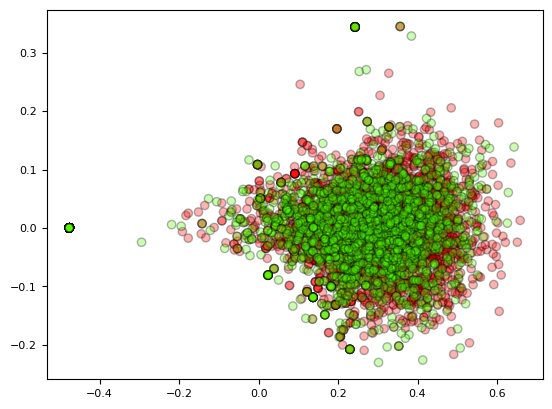

In [14]:
# dataset dist
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_dist)
plot_pca(X_pca, labels_train)

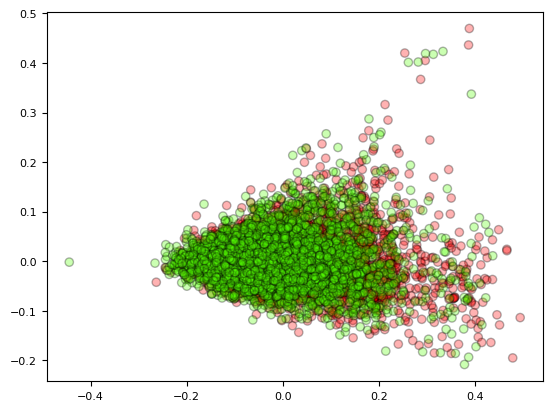

In [15]:
# dataset diff
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_diff)
plot_pca(X_pca, labels_train)

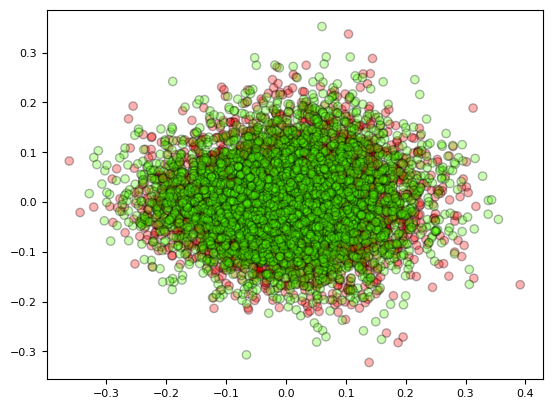

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_mean)
plot_pca(X_pca, labels_train)

### Salvataggio dei dataset

Dopo qualche prova in validazione, per tutti e tre i dataset la normalizzazione sembra abbassare leggermente le prestazioni, quindi non sarà utilizzata.

In [23]:
np.savez(file='../data/we/TED_we_mean', X_train=X_train_mean, y_train=labels_train, X_test=X_test_mean, y_test=labels_test)
np.savez(file='../data/we/TED_we_diff', X_train=X_train_diff, y_train=labels_train, X_test=X_test_diff, y_test=labels_test)
np.savez(file='../data/we/TED_we_dist', X_train=X_train_dist, y_train=labels_train, X_test=X_test_dist, y_test=labels_test)